In [827]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_parquet('../data/songs_optimized.parquet')

# Pre-procesado del dataframe

In [828]:
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [829]:
df.dtypes

Artist(s)                         category
song                                object
text                                object
Length                              object
emotion                           category
Genre                             category
Album                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Re

In [830]:
#guardar nombre de las canciones, para la validación?
nameSongs = df['song']

In [831]:
#columnas a eliminar que no tienen relevancia para predecir la popularidad
columnas_innecesarias = ['Artist(s)', 'text', 'Similar Artist 1', 'Similar Song 1', 'Similar Artist 2', 'Similar Song 2',
                         'Similar Artist 3', 'Similar Song 3', 'Similarity Score 1', 'Similarity Score 2', 'Similarity Score 3',
                         'song', 'Album']

#eliminar release date??

In [832]:
#eliminar columnas
df.drop(columns = columnas_innecesarias, inplace = True)

In [833]:
df.dtypes

Length                              object
emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Relaxation/Meditation        bool
Good for Exercise                     bool
Good for Running                      bool
Good for Yoga/Stretching              bool
Good for Dr

In [834]:
#ver si faltan datos
df.isnull().sum()

Length                            0
emotion                           0
Genre                             0
Release Date                      0
Key                               0
Tempo                             0
Loudness (db)                     0
Time signature                    8
Explicit                          0
Popularity                        0
Energy                            0
Danceability                      0
Positiveness                      0
Speechiness                       0
Liveness                          0
Acousticness                      0
Instrumentalness                  0
Good for Party                    0
Good for Work/Study               0
Good for Relaxation/Meditation    0
Good for Exercise                 0
Good for Running                  0
Good for Yoga/Stretching          0
Good for Driving                  0
Good for Social Gatherings        0
Good for Morning Routine          0
dtype: int64

In [835]:
#en las siguientes líneas de código se van a formatear
#todas las columnas para que tengan entradas numéricas

In [836]:
#convertir duración de la canción a segundos
df['Duration_sec'] = df['Length'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
df.drop(columns=['Length'], inplace=True)  # eliminar la columna original

In [837]:
#convertir Loudness a valor numérico (quitar db y que no sea object)
df['Loudness (db)'] = df['Loudness (db)'].str.replace('db', '', regex=False).str.strip()
df['Loudness (db)'] = pd.to_numeric(df['Loudness (db)'], errors='coerce')

In [838]:
#confirmar si se hizo bien la conversión
print(f"Valores NaN en Loudness (db): {df['Loudness (db)'].isna().sum()}")

Valores NaN en Loudness (db): 0


In [839]:
print(df['Loudness (db)'].head())


0   -6.85
1   -5.75
2   -6.06
3   -5.42
4   -5.57
Name: Loudness (db), dtype: float64


In [840]:
#convertir columnas booleanas a valor 0 y 1
#identificar las columnas
bool_cols = df.select_dtypes(include='bool').columns
#hacer conversión
df[bool_cols] = df[bool_cols].astype(int)

In [841]:
#ver datos
print(df[bool_cols].head())

   Explicit  Good for Party  Good for Work/Study  \
0         0               0                    0   
1         0               0                    0   
2         0               0                    0   
3         0               0                    0   
4         0               0                    0   

   Good for Relaxation/Meditation  Good for Exercise  Good for Running  \
0                               0                  0                 0   
1                               0                  0                 0   
2                               0                  1                 0   
3                               0                  1                 0   
4                               0                  1                 0   

   Good for Yoga/Stretching  Good for Driving  Good for Social Gatherings  \
0                         0                 0                           0   
1                         0                 0                           0   
2          

In [842]:
df.dtypes

emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                      float64
Time signature                    category
Explicit                             int64
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int64
Good for Work/Study                  int64
Good for Relaxation/Meditation       int64
Good for Exercise                    int64
Good for Running                     int64
Good for Yoga/Stretching             int64
Good for Driving                     int64
Good for So

In [843]:
#ver cantidad de valores distintos
df['emotion'].nunique(), df['Genre'].nunique()

(13, 3097)

In [844]:
df['emotion'].value_counts(dropna=False)

emotion
joy          209009
sadness      171078
anger        109678
fear          28097
love          27963
surprise       5592
True             17
Love              3
pink              2
confusion         1
angry             1
interest          1
thirst            1
Name: count, dtype: int64

In [845]:
#convertir amociones a  minúscula y eliminar espacios
df['emotion'] = df['emotion'].astype(str).str.lower().str.strip()

In [846]:
# mapeo de emociones válidas
emotion_map = {
    'sadness': 'sadness',
    'joy': 'joy',
    'love': 'love',
    'surprise': 'surprise',
    'anger': 'anger',
    'angry': 'anger',
    'fear': 'fear'
}
df['emotion'] = df['emotion'].map(emotion_map).fillna('unknown')

#como solo hay 22 canciones con valores inválidos se eliminan
df = df[df['emotion'] != 'unknown']

In [847]:
print(df['emotion'].value_counts())

emotion
joy         209009
sadness     171078
anger       109679
fear         28097
love         27966
surprise      5592
Name: count, dtype: int64


In [848]:
#cantidad de filas con valores NaN apra time signature
num_nan = df['Time signature'].isna().sum()
print(f"Cantidad de filas con NaN en time_signature: {num_nan}")

Cantidad de filas con NaN en time_signature: 8


In [849]:
#liminar filas con valoes NaN como son pocas
df = df.dropna(subset=['Time signature'])

In [850]:
num_nan = df['Time signature'].isna().sum()
print(f"Cantidad de filas con NaN en time_signature: {num_nan}")

Cantidad de filas con NaN en time_signature: 0


In [851]:
num_nan = df['emotion'].isna().sum()
print(f"Cantidad de filas con NaN : {num_nan}")

Cantidad de filas con NaN : 0


In [852]:
#Popularidad promedio por emoción (antes de OneHot)
if 'emotion' in df.columns:                          # por si aún existe la columna original
    pop_by_emo = df.groupby('emotion')['Popularity'].mean().sort_values(ascending=False)
    print("\nPopularidad promedio por emoción:")
    print(pop_by_emo)


Popularidad promedio por emoción:
emotion
love        33.024423
surprise    32.609800
joy         32.442581
anger       32.292007
fear        31.977044
sadness     31.921186
Name: Popularity, dtype: float64


In [853]:
good_for_cols = [
    'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
    'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine'
]
# Agrupar por emoción y luego calcular el promedio para cada good_for
resultados = []

for contexto in good_for_cols:
    subset = df[df[contexto] == 1]
    promedio = subset.groupby('emotion')['Popularity'].mean().reset_index()
    promedio['contexto'] = contexto
    resultados.append(promedio)

# Unir datos
df_comb = pd.concat(resultados, ignore_index=True)

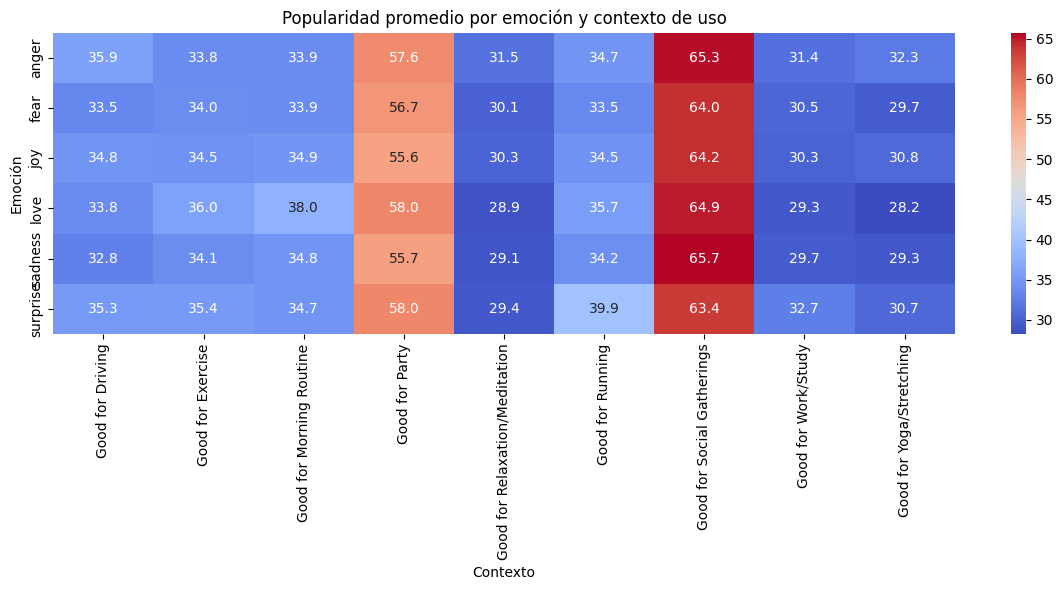

In [854]:
# Pivot para formato de matriz, emociones como fila y contextos como columna)
pivot_table = df_comb.pivot(index='emotion', columns='contexto', values='Popularity')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Popularidad promedio por emoción y contexto de uso")
plt.ylabel("Emoción")
plt.xlabel("Contexto")
plt.tight_layout()
plt.show()

In [855]:
num_nan = df['Key'].isna().sum()
print(f"Cantidad de filas con NaN: {num_nan}")

Cantidad de filas con NaN: 0


In [856]:
#hacer one hot encodig para las columnas de tipo category
colTypeCategory = ['emotion', 'Key', 'Time signature']
encoder = OneHotEncoder(sparse_output = False) #retorne un array denso
encoded = encoder.fit_transform(df[colTypeCategory]) #aplicar encoder a las columnas

#convertir el array a un dataframe
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(colTypeCategory))
#eliminar columnas de tipo category
df = df.drop(colTypeCategory, axis=1)
#añadir columnas de encoded_df al df original
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [857]:
df.dtypes

Genre                             category
Release Date                        object
Tempo                                int64
Loudness (db)                      float64
Explicit                             int64
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int64
Good for Work/Study                  int64
Good for Relaxation/Meditation       int64
Good for Exercise                    int64
Good for Running                     int64
Good for Yoga/Stretching             int64
Good for Driving                     int64
Good for Social Gatherings           int64
Good for Morning Routine             int64
Duration_sec                         int64
emotion_ang

In [858]:
timeSignature_cols = [col for col in df.columns if col.startswith('Time signature')]
print(timeSignature_cols)

['Time signature_1/4', 'Time signature_3/4', 'Time signature_4/4', 'Time signature_5/4']


In [859]:
key_cols = [col for col in df.columns if col.startswith('Key_')]
print("Categorías de key codificadas:", key_cols)

Categorías de key codificadas: ['Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min']


In [860]:
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
print("Categorías de emotion codificadas:", emotion_cols)

Categorías de emotion codificadas: ['emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise']


In [861]:
#convertir a valores enteros las columnas generadas por one hot encoding
time_signature_columnas = [col for col in df.columns if col.startswith('Time signature_')]
df[time_signature_columnas] = df[time_signature_columnas].astype(int)
emotion_columnas = [col for col in df.columns if col.startswith('emotion_')]
df[emotion_columnas] = df[emotion_columnas].astype(int)
key_columnas = [col for col in df.columns if col.startswith('Key_')]
df[key_columnas] = df[key_columnas].astype(int)

In [862]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551413 entries, 0 to 551412
Data columns (total 57 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Genre                           551413 non-null  category
 1   Release Date                    551413 non-null  object  
 2   Tempo                           551413 non-null  int64   
 3   Loudness (db)                   551413 non-null  float64 
 4   Explicit                        551413 non-null  int64   
 5   Popularity                      551413 non-null  uint8   
 6   Energy                          551413 non-null  uint8   
 7   Danceability                    551413 non-null  uint8   
 8   Positiveness                    551413 non-null  uint8   
 9   Speechiness                     551413 non-null  uint8   
 10  Liveness                        551413 non-null  uint8   
 11  Acousticness                    551413 non-null  uint8   
 12  In

In [863]:
num_nan = df['Genre'].isna().sum()
print(f"Cantidad de filas con NaN: {num_nan}")

Cantidad de filas con NaN: 0


In [864]:
#con genre no era conveniente hace One Hot coding, porque creaba una columna por cada
#combinación de géneros que tenía una canción, y se quiere una columna por cada género único

#crear lista con los géneros presentes en el dataset
df['listaGeneros'] = df['Genre'].str.split(',')
#apra usar el codificador
mlb = MultiLabelBinarizer()
#asignación de 0 y 1 por cada lista de géneros en Genre por canción
listaGenreBinario = pd.DataFrame(mlb.fit_transform(df['listaGeneros']),
                             columns=[f'Genre_{g.strip()}' for g in mlb.classes_],
                             index=df.index)
#agregar las columnnas por cada género al df
df = pd.concat([df, listaGenreBinario], axis=1)

#sacar las columnas que no se necesitan
df.drop(columns=['Genre', 'listaGeneros'], inplace=True)

In [865]:
df.dtypes

Release Date           object
Tempo                   int64
Loudness (db)         float64
Explicit                int64
Popularity              uint8
                       ...   
Genre_thrash metal      int64
Genre_trance            int64
Genre_trap              int64
Genre_trip-hop          int64
Genre_worship           int64
Length: 144, dtype: object

In [866]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
print(genre_cols)

['Genre_acoustic', 'Genre_alt-country', 'Genre_alternative', 'Genre_alternative rock', 'Genre_ambient', 'Genre_black metal', 'Genre_blues', 'Genre_britpop', 'Genre_chillout', 'Genre_chillwave', 'Genre_christian', 'Genre_classic rock', 'Genre_classical', 'Genre_cloud rap', 'Genre_comedy', 'Genre_country', 'Genre_dance', 'Genre_dancehall', 'Genre_death metal', 'Genre_deathcore', 'Genre_disco', 'Genre_doom metal', 'Genre_dream pop', 'Genre_drum and bass', 'Genre_dub', 'Genre_dubstep', 'Genre_electro', 'Genre_electronic', 'Genre_electropop', 'Genre_emo', 'Genre_emo rap', 'Genre_experimental', 'Genre_folk', 'Genre_funk', 'Genre_garage rock', 'Genre_gospel', 'Genre_grime', 'Genre_grunge', 'Genre_hard rock', 'Genre_hardcore', 'Genre_heavy metal', 'Genre_hip hop', 'Genre_hip-hop', 'Genre_house', 'Genre_indie', 'Genre_indie pop', 'Genre_indie rock', 'Genre_industrial', 'Genre_j-pop', 'Genre_jazz', 'Genre_k-pop', 'Genre_latin', 'Genre_lo-fi', 'Genre_math rock', 'Genre_melodic death metal', 'Genr

In [867]:
#unir en una sola columna la columna Genre_hip hop y Genre_hip-hop 
df['Genre_hip-hop'] = df['Genre_hip hop'] | df['Genre_hip-hop']
df['Genre_hip-hop'] = df['Genre_hip-hop'].astype(int)

# eliminar columna Genre_hip hop
df = df.drop(columns=['Genre_hip hop'])

In [868]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]  # todas las columnas de género
genre_counts = df[genre_cols].sum().sort_values(ascending=False)  # suma cuántas veces aparece cada género
print(genre_counts)

Genre_hip-hop             293652
Genre_rock                 84108
Genre_pop                  64385
Genre_alternative rock     40271
Genre_indie rock           22743
                           ...  
Genre_alt-country            602
Genre_worship                450
Genre_psychedelic            323
Genre_chillout               149
Genre_reggaeton               34
Length: 87, dtype: int64


In [869]:
print(df.columns.tolist())
print(df.info())

['Release Date', 'Tempo', 'Loudness (db)', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Duration_sec', 'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise', 'Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min', 'Time signature_1/4', 'Time signature_3/4', 'Time signature_4/4', 'Time signature_5/4', 'Genre_acoustic', 'Genre_alt-country', 'Genre_alternative', 'Genre_alternat

In [870]:
df.drop(columns=['Release Date'], inplace=True)


In [871]:
df

,Tempo,Loudness (db),Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,...,Genre_soul,Genre_soundtrack,Genre_swing,Genre_synthpop,Genre_techno,Genre_thrash metal,Genre_trance,Genre_trap,Genre_trip-hop,Genre_worship
0,105,-6.85,0,40,83,71,87,4,16,11,...,0,0,0,0,0,0,0,0,0,0
1,117,-5.75,0,42,85,70,87,4,32,0,...,0,0,0,0,0,0,0,0,0,0
2,121,-6.06,0,29,89,71,63,8,64,0,...,0,0,0,0,0,0,0,0,0,0
3,122,-5.42,0,24,84,78,97,4,12,12,...,0,0,0,0,0,0,0,0,0,0
4,123,-5.57,0,30,71,77,70,7,10,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551408,140,-10.00,1,31,82,83,19,16,9,39,...,0,0,0,0,0,0,0,0,0,0
551409,128,-9.68,0,29,43,39,26,3,10,54,...,0,0,0,0,0,0,0,0,0,0
551410,75,-4.67,0,21,79,56,41,5,19,0,...,0,0,0,0,0,0,0,0,0,0
551411,126,-3.93,0,5,90,59,69,4,7,27,...,0,0,0,0,0,0,0,0,0,0


# Análisis exploratorio

In [872]:
#Hacer análisis exploratorio
df.corr()

,Tempo,Loudness (db),Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,...,Genre_soul,Genre_soundtrack,Genre_swing,Genre_synthpop,Genre_techno,Genre_thrash metal,Genre_trance,Genre_trap,Genre_trip-hop,Genre_worship
Tempo,1.000000,0.127042,-0.012298,0.009248,0.178303,-0.111893,0.027774,0.009046,0.011176,-0.150223,...,-0.024750,0.000273,-0.011896,0.005868,0.008442,0.016559,0.004035,0.031802,0.001681,0.007503
Loudness (db),0.127042,1.000000,0.145099,0.088323,0.746677,0.112151,0.173336,0.060385,0.084055,-0.543750,...,-0.037585,-0.025624,-0.046705,-0.000314,0.004478,0.028797,-0.007929,0.030360,-0.006240,0.009916
Explicit,-0.012298,0.145099,1.000000,0.004827,0.095770,0.324089,0.028230,0.494201,0.031349,-0.161329,...,-0.075702,-0.011215,-0.015167,-0.056466,-0.019528,-0.005829,-0.011793,0.220525,-0.016094,-0.018298
Popularity,0.009248,0.088323,0.004827,1.000000,0.046767,0.107893,0.080540,-0.080392,-0.055607,-0.061171,...,0.028496,-0.017046,0.005966,0.030037,0.005017,0.003265,-0.010077,0.086715,0.017166,-0.009460
Energy,0.178303,0.746677,0.095770,0.046767,1.000000,-0.007537,0.258183,0.108398,0.177924,-0.672723,...,-0.063814,-0.021942,-0.065455,0.020060,0.010893,0.086155,0.005672,-0.006106,-0.000005,0.011001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Genre_thrash metal,0.016559,0.028797,-0.005829,0.003265,0.086155,-0.087435,-0.044834,0.001074,0.003441,-0.056699,...,-0.012537,-0.005813,-0.005654,-0.009471,-0.002888,1.000000,-0.004849,-0.012284,-0.002513,-0.002076
Genre_trance,0.004035,-0.007929,-0.011793,-0.010077,0.005672,0.007737,-0.000809,-0.008612,0.002200,-0.004392,...,-0.011519,-0.005341,-0.005195,0.017270,0.028975,-0.004849,1.000000,-0.011286,0.010329,-0.001908
Genre_trap,0.031802,0.030360,0.220525,0.086715,-0.006106,0.115528,-0.029063,0.121741,-0.006244,-0.041963,...,-0.024176,-0.013529,-0.013159,-0.022043,-0.006721,-0.012284,-0.011286,1.000000,-0.005849,-0.004832
Genre_trip-hop,0.001681,-0.006240,-0.016094,0.017166,-0.000005,-0.000609,-0.006924,-0.011111,0.001478,-0.004143,...,-0.002837,0.026941,-0.002692,-0.004510,-0.001375,-0.002513,0.010329,-0.005849,1.000000,-0.000989


In [873]:
df.corr()['Popularity'].sort_values(ascending=False)

Popularity                    1.000000
Good for Party                0.342266
Good for Social Gatherings    0.201443
Genre_pop                     0.108395
Danceability                  0.107893
                                ...   
Time signature_3/4           -0.044810
Genre_hip-hop                -0.046509
Liveness                     -0.055607
Acousticness                 -0.061171
Speechiness                  -0.080392
Name: Popularity, Length: 142, dtype: float64

In [874]:
df.corr()['Popularity'].sort_values(ascending=False).to_csv('correlaciones_popularity.csv')

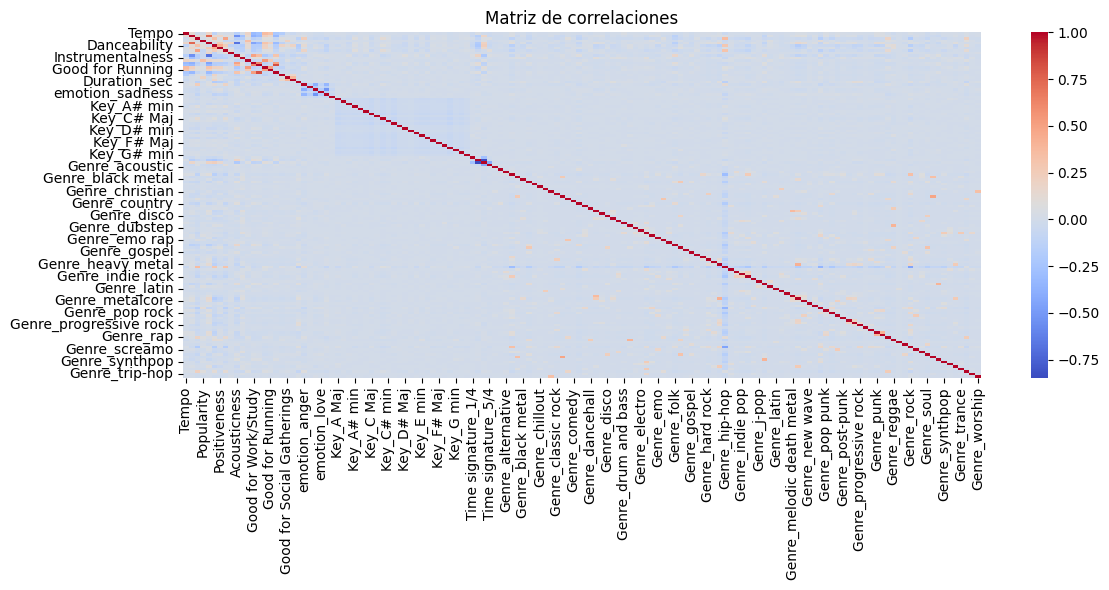

In [875]:
# 1) Matriz de correlaciones numéricas
plt.figure(figsize=(12, 6))
corr = df.corr(numeric_only=True)          # solo columnas numéricas
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.tight_layout()
plt.show()

In [876]:
#calcular la popularidad promedio por cada columna good_for_*
good_for_cols = [c for c in df.columns if c.startswith('Good for')]
for col in good_for_cols:
    mean_pop = df.loc[df[col] == 1, 'Popularity'].mean()
    print(f"Popularidad promedio cuando {col}=1  →  {mean_pop:.2f}")

Popularidad promedio cuando Good for Party=1  →  56.31
Popularidad promedio cuando Good for Work/Study=1  →  30.16
Popularidad promedio cuando Good for Relaxation/Meditation=1  →  29.87
Popularidad promedio cuando Good for Exercise=1  →  34.27
Popularidad promedio cuando Good for Running=1  →  34.53
Popularidad promedio cuando Good for Yoga/Stretching=1  →  30.16
Popularidad promedio cuando Good for Driving=1  →  34.41
Popularidad promedio cuando Good for Social Gatherings=1  →  64.87
Popularidad promedio cuando Good for Morning Routine=1  →  34.84


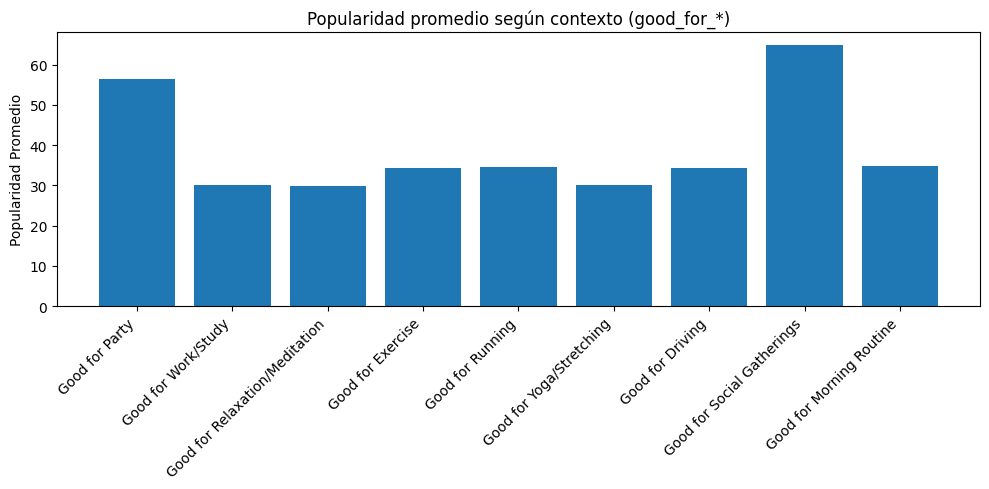

In [877]:
context_columns = [
    'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
    'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine'
]

promedios = {
    col: df[df[col] == 1]['Popularity'].mean()
    for col in context_columns
}

plt.figure(figsize=(10, 5))
plt.bar(promedios.keys(), promedios.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Popularidad Promedio")
plt.title("Popularidad promedio según contexto (good_for_*)")
plt.tight_layout()
plt.show()

# Modelo de Red Neuronal MLP

## División del dataset

In [ ]:
# Dividir el DataFrame en conjuntos de entrenamiento, validación y prueba
# Se usa un 70% para entrenamiento, un 15% para validación y 15% de prueba

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, shuffle=False)

# Normalizar la columna 'Popularity' entre 0 y 1
scaler = MinMaxScaler()
train_df['Popularity'] = scaler.fit_transform(train_df[['Popularity']])
val_df['Popularity'] = scaler.transform(val_df[['Popularity']])
test_df['Popularity'] = scaler.transform(test_df[['Popularity']])

In [917]:
print(f'Train: {val_df.shape},  Val: {test_df.shape},  Test: {train_df.shape}')

Train: (82712, 142),  Val: (82712, 142),  Test: (385989, 142)


## Modelo popularidad general

### Pre-procesado de datos

In [918]:
# Convertir el DataFrame a tensores de PyTorch
X_train = torch.tensor(train_df.drop(columns=['Popularity']).values, dtype=torch.float32)  
X_train = DataLoader(X_train, batch_size=8578, shuffle=False)  # Crear DataLoader para el conjunto de entrenamiento
y_train = torch.tensor(train_df['Popularity'].values, dtype=torch.float32).view(-1, 1)  # Asegurarse de que y tenga la forma correcta
y_train = DataLoader(y_train, batch_size=8578, shuffle=False)  # Crear DataLoader para las etiquetas de entrenamiento

X_val = torch.tensor(val_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_val = DataLoader(X_val, batch_size=3938, shuffle=False)  # Crear DataLoader para el conjunto de validación
y_val = torch.tensor(val_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_val = DataLoader(y_val, batch_size=3938, shuffle=False)  # Crear DataLoader para las etiquetas de validación


X_test = torch.tensor(test_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_test = DataLoader(X_test, batch_size=3939, shuffle=False)  # Crear DataLoader para el conjunto de prueba
y_test = torch.tensor(test_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_test = DataLoader(y_test, batch_size=3939, shuffle=False)  # Crear DataLoader para las etiquetas de prueba


In [919]:
len(X_train), len(X_val), len(X_test)

(45, 22, 21)

### Modelo HL 2, LR 0.0005

#### Modelo

In [920]:
#Modelo de red neuronal
class MLP_P(nn.Module):
    def __init__(self, hidden_size=10, input_size=141):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l2 = self.act(l2)     #activación
        output = self.out(l2)   #salida
        return output

#### Prueba del modelo

In [921]:
# Crear modelo
model = MLP_P()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,420
            Linear-2                [-1, 1, 10]             110
              ReLU-3                [-1, 1, 10]               0
            Linear-4                 [-1, 1, 1]              11
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [922]:
#Instanciar el modelo
model = MLP_P(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [ ]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:   
    # Entrenamiento 
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]


Época 1 | Train Loss: 0.3282 | Val Loss: 0.0413
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 45/45 [00:01<00:00, 23.40it/s]


Época 2 | Train Loss: 0.0409 | Val Loss: 0.0329
Nuevo mínimo en loss de validación


Epoch 3: 100%|██████████| 45/45 [00:01<00:00, 25.24it/s]


Época 3 | Train Loss: 0.0362 | Val Loss: 0.0310
Nuevo mínimo en loss de validación


Epoch 4: 100%|██████████| 45/45 [00:02<00:00, 21.73it/s]

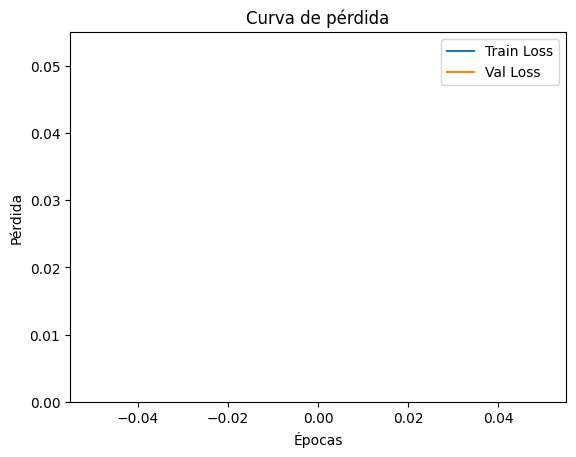

In [ ]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0)
plt.show()

#### Testeo del modelo

In [ ]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0215


In [ ]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.11
MSE: 0.02
RMSE: 0.15
R²: 0.13


### Modelo HL 3, LR 0.0005

#### Modelo

In [ ]:
#Modelo de red neuronal
class MLP_P3(nn.Module):
    def __init__(self, hidden_size=10, input_size=141):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)  #de capa oculta a capa oculta
        l3 = self.act(l3)     #activación
        output = self.out(l3)   #salida
        return output

#### Prueba del modelo

In [ ]:
# Crear modelo
model = MLP_P3()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,430
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
              ReLU-4                [-1, 1, 10]               0
            Linear-5                 [-1, 1, 1]              11
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [ ]:
# Instanciar el modelo
model = MLP_P3(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer


#### Entrenamiento del modelo

In [ ]:
#Loop de entrenamiento
epoch = 0
patience=10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P3.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 45/45 [00:06<00:00,  6.91it/s]


Época 1 | Train Loss: 0.1367 | Val Loss: 0.0380
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 45/45 [00:06<00:00,  7.20it/s]


Época 2 | Train Loss: 0.0404 | Val Loss: 0.0327
Nuevo mínimo en loss de validación


Epoch 3: 100%|██████████| 45/45 [00:06<00:00,  7.37it/s]


Época 3 | Train Loss: 0.0365 | Val Loss: 0.0321
Nuevo mínimo en loss de validación


Epoch 4: 100%|██████████| 45/45 [00:06<00:00,  6.91it/s]


Época 4 | Train Loss: 0.0339 | Val Loss: 0.0317
Nuevo mínimo en loss de validación


Epoch 5: 100%|██████████| 45/45 [00:07<00:00,  6.38it/s]


Época 5 | Train Loss: 0.0320 | Val Loss: 0.0310
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 45/45 [00:06<00:00,  7.06it/s]


Época 6 | Train Loss: 0.0304 | Val Loss: 0.0301
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 45/45 [00:06<00:00,  6.93it/s]


Época 7 | Train Loss: 0.0289 | Val Loss: 0.0293
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 45/45 [00:06<00:00,  7.31it/s]


Época 8 | Train Loss: 0.0277 | Val Loss: 0.0287
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 45/45 [00:06<00:00,  7.15it/s]


Época 9 | Train Loss: 0.0268 | Val Loss: 0.0284
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 45/45 [00:06<00:00,  6.79it/s]


Época 10 | Train Loss: 0.0262 | Val Loss: 0.0283
Nuevo mínimo en loss de validación


Epoch 11: 100%|██████████| 45/45 [00:06<00:00,  6.85it/s]


Época 11 | Train Loss: 0.0257 | Val Loss: 0.0284


Epoch 12: 100%|██████████| 45/45 [00:06<00:00,  6.94it/s]


Época 12 | Train Loss: 0.0255 | Val Loss: 0.0285


Epoch 13: 100%|██████████| 45/45 [00:06<00:00,  6.85it/s]


Época 13 | Train Loss: 0.0253 | Val Loss: 0.0286


Epoch 14: 100%|██████████| 45/45 [00:06<00:00,  7.33it/s]


Época 14 | Train Loss: 0.0252 | Val Loss: 0.0320


Epoch 15: 100%|██████████| 45/45 [00:05<00:00,  7.60it/s]


Época 15 | Train Loss: 0.0284 | Val Loss: 0.0285


Epoch 16: 100%|██████████| 45/45 [00:06<00:00,  6.96it/s]


Época 16 | Train Loss: 0.0252 | Val Loss: 0.0285


Epoch 17: 100%|██████████| 45/45 [00:05<00:00,  7.88it/s]


Época 17 | Train Loss: 0.0250 | Val Loss: 0.0286


Epoch 18: 100%|██████████| 45/45 [00:06<00:00,  7.12it/s]


Época 18 | Train Loss: 0.0250 | Val Loss: 0.0286


Epoch 19: 100%|██████████| 45/45 [00:06<00:00,  6.69it/s]


Época 19 | Train Loss: 0.0290 | Val Loss: 0.0430


Epoch 20: 100%|██████████| 45/45 [00:06<00:00,  7.22it/s]


Época 20 | Train Loss: 0.0266 | Val Loss: 0.0284
Early stopping triggered


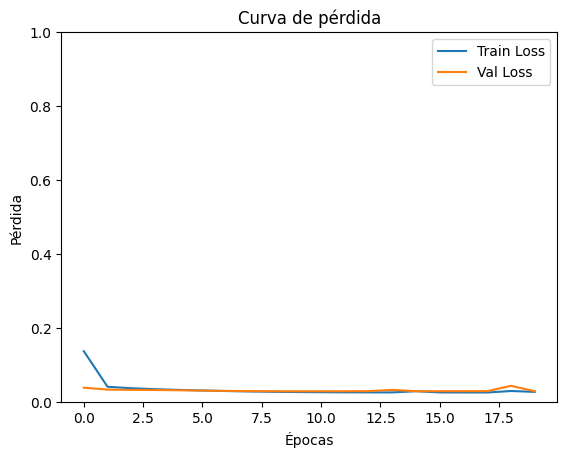

In [ ]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0)
plt.show()

#### Testeo del modelo

In [ ]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P3.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0217


In [ ]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.11
MSE: 0.02
RMSE: 0.15
R²: 0.12


### Modelo HL 4, LR 0.0001

#### Model

In [ ]:
#Modelo de red neuronal
class MLP_P4(nn.Module):
    def __init__(self, hidden_size=10, input_size=141):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h4 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)
        l4 = self.h2(l3)  #de capa oculta a capa oculta
        l4 = self.act(l4)     #activación
        output = self.out(l4)   #salida
        return output

#### Prueba del modelo

In [ ]:
# Crear modelo
model = MLP_P4()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,430
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                [-1, 1, 10]             110
              ReLU-5                [-1, 1, 10]               0
            Linear-6                 [-1, 1, 1]              11
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [ ]:
# Instanciar el modelo
model = MLP_P4(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [ ]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P4.pth')
        
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 45/45 [00:06<00:00,  6.87it/s]


Época 1 | Train Loss: 0.2053 | Val Loss: 0.0334
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 45/45 [00:06<00:00,  7.35it/s]


Época 2 | Train Loss: 0.0444 | Val Loss: 0.0349


Epoch 3: 100%|██████████| 45/45 [00:05<00:00,  7.84it/s]


Época 3 | Train Loss: 0.0423 | Val Loss: 0.0343


Epoch 4: 100%|██████████| 45/45 [00:06<00:00,  6.63it/s]


Época 4 | Train Loss: 0.0410 | Val Loss: 0.0333
Nuevo mínimo en loss de validación


Epoch 5: 100%|██████████| 45/45 [00:06<00:00,  6.88it/s]


Época 5 | Train Loss: 0.0397 | Val Loss: 0.0324
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 45/45 [00:06<00:00,  7.14it/s]


Época 6 | Train Loss: 0.0383 | Val Loss: 0.0315
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 45/45 [00:06<00:00,  7.09it/s]


Época 7 | Train Loss: 0.0369 | Val Loss: 0.0307
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 45/45 [00:05<00:00,  7.60it/s]


Época 8 | Train Loss: 0.0353 | Val Loss: 0.0302
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 45/45 [00:06<00:00,  7.24it/s]


Época 9 | Train Loss: 0.0337 | Val Loss: 0.0299
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 45/45 [00:06<00:00,  6.90it/s]


Época 10 | Train Loss: 0.0323 | Val Loss: 0.0298
Nuevo mínimo en loss de validación


Epoch 11: 100%|██████████| 45/45 [00:06<00:00,  6.98it/s]


Época 11 | Train Loss: 0.0311 | Val Loss: 0.0295
Nuevo mínimo en loss de validación


Epoch 12: 100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


Época 12 | Train Loss: 0.0300 | Val Loss: 0.0291
Nuevo mínimo en loss de validación


Epoch 13: 100%|██████████| 45/45 [00:06<00:00,  6.65it/s]


Época 13 | Train Loss: 0.0289 | Val Loss: 0.0285
Nuevo mínimo en loss de validación


Epoch 14: 100%|██████████| 45/45 [00:06<00:00,  7.32it/s]


Época 14 | Train Loss: 0.0279 | Val Loss: 0.0280
Nuevo mínimo en loss de validación


Epoch 15: 100%|██████████| 45/45 [00:06<00:00,  7.21it/s]


Época 15 | Train Loss: 0.0271 | Val Loss: 0.0275
Nuevo mínimo en loss de validación


Epoch 16: 100%|██████████| 45/45 [00:06<00:00,  7.23it/s]


Época 16 | Train Loss: 0.0264 | Val Loss: 0.0273
Nuevo mínimo en loss de validación


Epoch 17: 100%|██████████| 45/45 [00:05<00:00,  7.59it/s]


Época 17 | Train Loss: 0.0259 | Val Loss: 0.0272
Nuevo mínimo en loss de validación


Epoch 18: 100%|██████████| 45/45 [00:06<00:00,  7.23it/s]


Época 18 | Train Loss: 0.0256 | Val Loss: 0.0272


Epoch 19: 100%|██████████| 45/45 [00:06<00:00,  6.49it/s]


Época 19 | Train Loss: 0.0253 | Val Loss: 0.0273


Epoch 20: 100%|██████████| 45/45 [00:05<00:00,  7.51it/s]


Época 20 | Train Loss: 0.0252 | Val Loss: 0.0275


Epoch 21: 100%|██████████| 45/45 [00:05<00:00,  8.14it/s]


Época 21 | Train Loss: 0.0251 | Val Loss: 0.0276


Epoch 22: 100%|██████████| 45/45 [00:06<00:00,  7.40it/s]


Época 22 | Train Loss: 0.0284 | Val Loss: 0.0273


Epoch 23: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]


Época 23 | Train Loss: 0.0261 | Val Loss: 0.0275


Epoch 24: 100%|██████████| 45/45 [00:06<00:00,  7.04it/s]


Época 24 | Train Loss: 0.0250 | Val Loss: 0.0275


Epoch 25: 100%|██████████| 45/45 [00:07<00:00,  6.30it/s]


Época 25 | Train Loss: 0.0250 | Val Loss: 0.0277


Epoch 26: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


Época 26 | Train Loss: 0.0249 | Val Loss: 0.0278


Epoch 27: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Época 27 | Train Loss: 0.0249 | Val Loss: 0.0278
Early stopping triggered


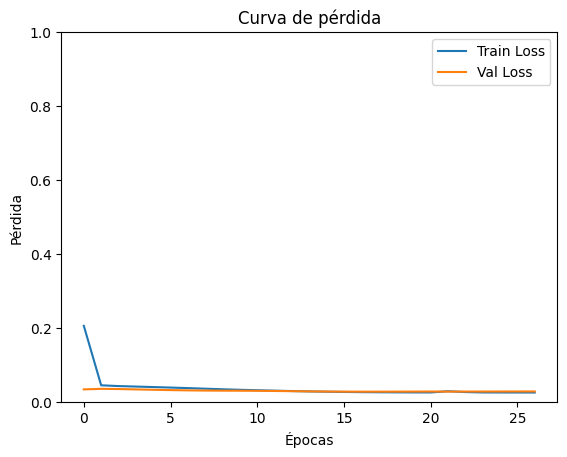

In [ ]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0, 1)
plt.show()

#### Testeo del modelo

In [ ]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P4.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0210


In [ ]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.11
MSE: 0.02
RMSE: 0.15
R²: 0.15


## Modelo popularidad segmentada

### Pre-procesado de datos

In [903]:
# Eliminar las columnas de contexto de uso y Popularity del DataFrame
temp_train = train_df.drop(columns=['Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
                                    'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
                                    'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine','Popularity'])
temp_val = val_df.drop(columns=['Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
                                'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
                                'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine','Popularity'])
temp_test = test_df.drop(columns=['Good for Party', 'Good for Work/Study','Good for Relaxation/Meditation',
                                  'Good for Exercise', 'Good for Running','Good for Yoga/Stretching',
                                  'Good for Driving', 'Good for Social Gatherings','Good for Morning Routine','Popularity'])

# Convertir el DataFrame a tensores de PyTorch
X_train = torch.tensor(temp_train.values, dtype=torch.float32)  
X_train = DataLoader(X_train, batch_size=8578, shuffle=False)  # Crear DataLoader para el conjunto de entrenamiento
y_train = torch.tensor(train_df['Popularity'].values, dtype=torch.float32).view(-1, 1)  # Asegurarse de que y tenga la forma correcta
y_train = DataLoader(y_train, batch_size=8578, shuffle=False)  # Crear DataLoader para las etiquetas de entrenamiento

X_val = torch.tensor(temp_val.values, dtype=torch.float32)
X_val = DataLoader(X_val, batch_size=3938, shuffle=False)  # Crear DataLoader para el conjunto de validación
y_val = torch.tensor(val_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_val = DataLoader(y_val, batch_size=3938, shuffle=False)  # Crear DataLoader para las etiquetas de validación


X_test = torch.tensor(temp_test.values, dtype=torch.float32)
X_test = DataLoader(X_test, batch_size=3939, shuffle=False)  # Crear DataLoader para el conjunto de prueba
y_test = torch.tensor(test_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_test = DataLoader(y_test, batch_size=3939, shuffle=False)  # Crear DataLoader para las etiquetas de prueba


In [904]:
len(X_train), len(X_val), len(X_test)

(45, 22, 21)

### Modelo HL 2, LR 0.0005

#### Modelo

In [905]:
#Modelo de red neuronal
class MLP_P(nn.Module):
    def __init__(self, hidden_size=10, input_size=133):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l2 = self.act(l2)     #activación
        output = self.out(l2)   #salida
        return output

#### Prueba del modelo

In [906]:
# Crear modelo
model = MLP_P()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 133).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 133))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,340
            Linear-2                [-1, 1, 10]             110
              ReLU-3                [-1, 1, 10]               0
            Linear-4                 [-1, 1, 1]              11
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [907]:
#Instanciar el modelo
model = MLP_P(hidden_size=10, input_size=len(df.columns)-10)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [908]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:   
    # Entrenamiento 
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 45/45 [00:06<00:00,  6.99it/s]


Época 1 | Train Loss: 0.9907 | Val Loss: 0.0914
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 45/45 [00:06<00:00,  7.21it/s]


Época 2 | Train Loss: 0.0574 | Val Loss: 0.0421
Nuevo mínimo en loss de validación


Epoch 3: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]


Época 3 | Train Loss: 0.0501 | Val Loss: 0.0402
Nuevo mínimo en loss de validación


Epoch 4: 100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


Época 4 | Train Loss: 0.0473 | Val Loss: 0.0381
Nuevo mínimo en loss de validación


Epoch 5: 100%|██████████| 45/45 [00:06<00:00,  7.37it/s]


Época 5 | Train Loss: 0.0451 | Val Loss: 0.0366
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 45/45 [00:06<00:00,  7.14it/s]


Época 6 | Train Loss: 0.0434 | Val Loss: 0.0355
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 45/45 [00:06<00:00,  7.10it/s]


Época 7 | Train Loss: 0.0420 | Val Loss: 0.0348
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 45/45 [00:06<00:00,  7.44it/s]


Época 8 | Train Loss: 0.0410 | Val Loss: 0.0343
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 45/45 [00:06<00:00,  6.53it/s]


Época 9 | Train Loss: 0.0401 | Val Loss: 0.0339
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 45/45 [00:06<00:00,  6.97it/s]


Época 10 | Train Loss: 0.0394 | Val Loss: 0.0336
Nuevo mínimo en loss de validación


Epoch 11: 100%|██████████| 45/45 [00:06<00:00,  7.19it/s]


Época 11 | Train Loss: 0.0388 | Val Loss: 0.0334
Nuevo mínimo en loss de validación


Epoch 12: 100%|██████████| 45/45 [00:06<00:00,  6.73it/s]


Época 12 | Train Loss: 0.0382 | Val Loss: 0.0333
Nuevo mínimo en loss de validación


Epoch 13: 100%|██████████| 45/45 [00:06<00:00,  7.11it/s]


Época 13 | Train Loss: 0.0376 | Val Loss: 0.0332
Nuevo mínimo en loss de validación


Epoch 14: 100%|██████████| 45/45 [00:06<00:00,  7.33it/s]


Época 14 | Train Loss: 0.0372 | Val Loss: 0.0332
Nuevo mínimo en loss de validación


Epoch 15: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


Época 15 | Train Loss: 0.0368 | Val Loss: 0.0332


Epoch 16: 100%|██████████| 45/45 [00:06<00:00,  7.08it/s]


Época 16 | Train Loss: 0.0364 | Val Loss: 0.0332


Epoch 17: 100%|██████████| 45/45 [00:06<00:00,  6.89it/s]


Época 17 | Train Loss: 0.0361 | Val Loss: 0.0333


Epoch 18: 100%|██████████| 45/45 [00:06<00:00,  6.94it/s]


Época 18 | Train Loss: 0.0358 | Val Loss: 0.0333


Epoch 19: 100%|██████████| 45/45 [00:06<00:00,  7.19it/s]


Época 19 | Train Loss: 0.0355 | Val Loss: 0.0333


Epoch 20: 100%|██████████| 45/45 [00:06<00:00,  7.31it/s]


Época 20 | Train Loss: 0.0352 | Val Loss: 0.0333


Epoch 21: 100%|██████████| 45/45 [00:06<00:00,  7.01it/s]


Época 21 | Train Loss: 0.0350 | Val Loss: 0.0332


Epoch 22: 100%|██████████| 45/45 [00:06<00:00,  6.95it/s]


Época 22 | Train Loss: 0.0348 | Val Loss: 0.0332
Nuevo mínimo en loss de validación


Epoch 23: 100%|██████████| 45/45 [00:06<00:00,  7.04it/s]


Época 23 | Train Loss: 0.0345 | Val Loss: 0.0331
Nuevo mínimo en loss de validación


Epoch 24: 100%|██████████| 45/45 [00:06<00:00,  7.18it/s]


Época 24 | Train Loss: 0.0343 | Val Loss: 0.0330
Nuevo mínimo en loss de validación


Epoch 25: 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]


Época 25 | Train Loss: 0.0341 | Val Loss: 0.0329
Nuevo mínimo en loss de validación


Epoch 26: 100%|██████████| 45/45 [00:06<00:00,  7.25it/s]


Época 26 | Train Loss: 0.0339 | Val Loss: 0.0328
Nuevo mínimo en loss de validación


Epoch 27: 100%|██████████| 45/45 [00:06<00:00,  7.11it/s]


Época 27 | Train Loss: 0.0337 | Val Loss: 0.0327
Nuevo mínimo en loss de validación


Epoch 28: 100%|██████████| 45/45 [00:06<00:00,  6.78it/s]


Época 28 | Train Loss: 0.0335 | Val Loss: 0.0326
Nuevo mínimo en loss de validación


Epoch 29: 100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


Época 29 | Train Loss: 0.0333 | Val Loss: 0.0325
Nuevo mínimo en loss de validación


Epoch 30: 100%|██████████| 45/45 [00:06<00:00,  7.08it/s]


Época 30 | Train Loss: 0.0331 | Val Loss: 0.0325
Nuevo mínimo en loss de validación


Epoch 31: 100%|██████████| 45/45 [00:06<00:00,  6.63it/s]


Época 31 | Train Loss: 0.0330 | Val Loss: 0.0324
Nuevo mínimo en loss de validación


Epoch 32: 100%|██████████| 45/45 [00:06<00:00,  7.30it/s]


Época 32 | Train Loss: 0.0328 | Val Loss: 0.0323
Nuevo mínimo en loss de validación


Epoch 33: 100%|██████████| 45/45 [00:05<00:00,  7.64it/s]


Época 33 | Train Loss: 0.0327 | Val Loss: 0.0322
Nuevo mínimo en loss de validación


Epoch 34: 100%|██████████| 45/45 [00:06<00:00,  6.79it/s]


Época 34 | Train Loss: 0.0326 | Val Loss: 0.0322
Nuevo mínimo en loss de validación


Epoch 35: 100%|██████████| 45/45 [00:06<00:00,  6.75it/s]


Época 35 | Train Loss: 0.0324 | Val Loss: 0.0321
Nuevo mínimo en loss de validación


Epoch 36: 100%|██████████| 45/45 [00:07<00:00,  6.33it/s]


Época 36 | Train Loss: 0.0323 | Val Loss: 0.0321
Nuevo mínimo en loss de validación


Epoch 37: 100%|██████████| 45/45 [00:07<00:00,  6.29it/s]


Época 37 | Train Loss: 0.0322 | Val Loss: 0.0320
Nuevo mínimo en loss de validación


Epoch 38: 100%|██████████| 45/45 [00:07<00:00,  6.20it/s]


Época 38 | Train Loss: 0.0321 | Val Loss: 0.0320
Nuevo mínimo en loss de validación


Epoch 39: 100%|██████████| 45/45 [00:06<00:00,  6.47it/s]


Época 39 | Train Loss: 0.0320 | Val Loss: 0.0320
Nuevo mínimo en loss de validación


Epoch 40: 100%|██████████| 45/45 [00:07<00:00,  5.95it/s]


Época 40 | Train Loss: 0.0320 | Val Loss: 0.0320
Nuevo mínimo en loss de validación


Epoch 41: 100%|██████████| 45/45 [00:06<00:00,  6.44it/s]


Época 41 | Train Loss: 0.0319 | Val Loss: 0.0320
Nuevo mínimo en loss de validación


Epoch 42: 100%|██████████| 45/45 [00:06<00:00,  6.54it/s]


Época 42 | Train Loss: 0.0318 | Val Loss: 0.0320


Epoch 43: 100%|██████████| 45/45 [00:07<00:00,  6.13it/s]


Época 43 | Train Loss: 0.0317 | Val Loss: 0.0320


Epoch 44: 100%|██████████| 45/45 [00:07<00:00,  5.68it/s]


Época 44 | Train Loss: 0.0317 | Val Loss: 0.0320


Epoch 45: 100%|██████████| 45/45 [00:07<00:00,  6.10it/s]


Época 45 | Train Loss: 0.0316 | Val Loss: 0.0320


Epoch 46: 100%|██████████| 45/45 [00:07<00:00,  5.83it/s]


Época 46 | Train Loss: 0.0315 | Val Loss: 0.0321


Epoch 47: 100%|██████████| 45/45 [00:08<00:00,  5.56it/s]


Época 47 | Train Loss: 0.0315 | Val Loss: 0.0321


Epoch 48: 100%|██████████| 45/45 [00:07<00:00,  6.07it/s]


Época 48 | Train Loss: 0.0314 | Val Loss: 0.0321


Epoch 49: 100%|██████████| 45/45 [00:07<00:00,  6.24it/s]


Época 49 | Train Loss: 0.0313 | Val Loss: 0.0321


Epoch 50: 100%|██████████| 45/45 [00:07<00:00,  5.80it/s]


Época 50 | Train Loss: 0.0313 | Val Loss: 0.0322


Epoch 51: 100%|██████████| 45/45 [00:06<00:00,  6.54it/s]


Época 51 | Train Loss: 0.0312 | Val Loss: 0.0322
Early stopping triggered


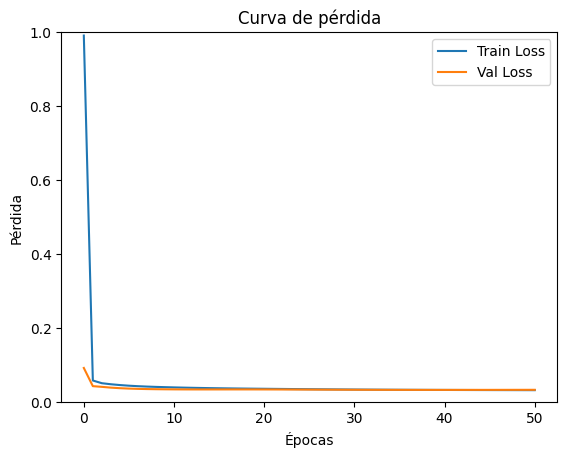

In [909]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0, 1)
plt.show()

#### Testeo del modelo

In [910]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0246


In [911]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.12
MSE: 0.02
RMSE: 0.16
R²: 0.00


### Modelo HL 3, LR 0.0005

#### Modelo

In [912]:
#Modelo de red neuronal
class MLP_P3(nn.Module):
    def __init__(self, hidden_size=10, input_size=133):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)  #de capa oculta a capa oculta
        l3 = self.act(l3)     #activación
        output = self.out(l3)   #salida
        return output

#### Prueba del modelo

In [913]:
# Crear modelo
model = MLP_P3()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 133).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 133))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,340
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
              ReLU-4                [-1, 1, 10]               0
            Linear-5                 [-1, 1, 1]              11
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [914]:
# Instanciar el modelo
model = MLP_P3(hidden_size=7, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer


#### Entrenamiento del modelo

In [915]:
#Loop de entrenamiento
epoch = 0
patience=10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P3.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1:   0%|          | 0/45 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8578x132 and 141x7)

In [ ]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0, 1)
plt.show()

#### Testeo del modelo

In [ ]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P3.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

### Modelo HL 4, LR 0.0001

#### Model

In [ ]:
#Modelo de red neuronal
class MLP_P4(nn.Module):
    def __init__(self, hidden_size=10, input_size=133):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h4 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)
        l4 = self.h2(l3)  #de capa oculta a capa oculta
        l4 = self.act(l4)     #activación
        output = self.out(l4)   #salida
        return output

#### Prueba del modelo

In [ ]:
# Crear modelo
model = MLP_P4()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 133).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 133))

#### Inicialización del modelo

In [ ]:
# Instanciar el modelo
model = MLP_P4(hidden_size=7, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [ ]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_val)), next(iter(y_val))
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P4.pth')
        
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

In [ ]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0, 1)
plt.show()

#### Testeo del modelo

In [ ]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P4.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for _ in range(len(X_test)):
        input, labels = next(iter(X_test)), next(iter(y_test))
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1)
y_true = np.concatenate(true).reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")